In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
config_df = pd.read_csv("bert_classifier_indo.csv")
config_df = config_df[~config_df['pooling_type'].isin(['cls_max', 'cls_mean', 'mean_max'])]
config_df = config_df[config_df['config_id'].isin([0, 1, 2, 8])]
epoch_df = pd.read_csv("bert_classifier_indo_epoch.csv")
epoch_df.head()
config_df.head(10)

,config_id,type_test,model_name,pooling_type,batch_size,epochs,learning_rate,attention_dropout,hidden_dropout,classifier_dropout,weight_decay,training_time,peak_memory,test_mse,test_mae,test_rmse,test_pearson
0,0,classifier,indobenchmark/indobert-lite-base-p2,cls,16,32,0.00002,0,0,0.1,0.01,2910.347867,4907.419434,0.006944,0.062267,0.083121,0.949429
1,1,classifier,indobenchmark/indobert-lite-base-p2,mean,16,20,0.00002,0,0,0.1,0.01,1824.897654,4908.895996,0.007276,0.063631,0.084682,0.946662
2,2,classifier,indobenchmark/indobert-lite-base-p2,max,16,17,0.00002,0,0,0.1,0.01,1551.854236,4908.895996,0.008872,0.071870,0.094152,0.935675
4,8,classifier,indobenchmark/indobert-lite-base-p2,attention,16,20,0.00002,0,0,0.1,0.01,1914.862080,4907.433105,0.007048,0.061836,0.083456,0.950447


# Training Plot

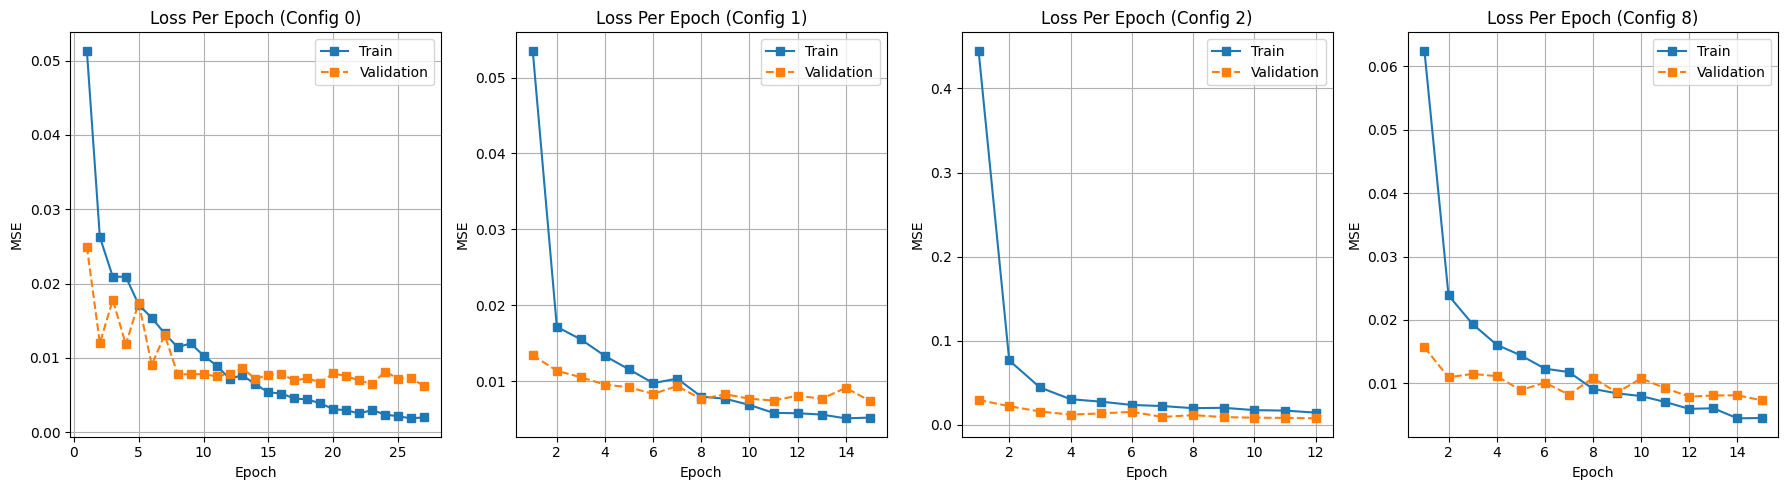

In [13]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 4, figsize=(18, 5)) 

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import BertTokenizer
from main_regression import RegressionModel, AutomaticScoringDataset
from torch.utils.data import DataLoader
import torch

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-lite-base-p2')
def predict(df_test, config_id, model):
    test_data = AutomaticScoringDataset(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    checkpoint = torch.load(f"../../../models/pooling/spesific/bert_classifier_indo_{config_id}.pt", map_location='cuda', weights_only=True)
    model.load_state_dict(checkpoint)
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batchs in test_dataloader:
            try:
                # move to device
                batchs = {k: v.to('cuda') for k, v in batchs.items()}
                predictions = model(
                    batchs['input_ids'], 
                    batchs['attention_mask'], 
                    batchs['token_type_ids']).squeeze(1)
                preds = torch.clamp(predictions, 0, 1)

                all_predictions.extend(preds.detach().cpu().numpy())
                all_targets.extend(batchs['labels'].detach().cpu().numpy())
            except Exception as e:
                torch.cuda.empty_cache()

    return all_predictions, all_targets

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

In [ ]:
import pandas as pd

df_test = pd.read_csv("../../../../data/clean/spesific/test_indo.csv")
for row in config_df.itertuples():
    model = RegressionModel('indobenchmark/indobert-lite-base-p2', pooling_type=row.pooling_type).to('cuda')
    all_predictions, all_targets = predict(df_test, row.config_id, model)

    df_test[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test, os.path.join(output_dir, "bert_predictions_indo1.csv"))


>> CLS Pooling - predicted_score_0
RMSE: 0.0824, Pearson: 0.9502

>> Mean Pooling - predicted_score_1
RMSE: 0.0832, Pearson: 0.9485

>> Max Pooling - predicted_score_2
RMSE: 0.0937, Pearson: 0.9360

>> Attention Pooling - predicted_score_8
RMSE: 0.0824, Pearson: 0.9515


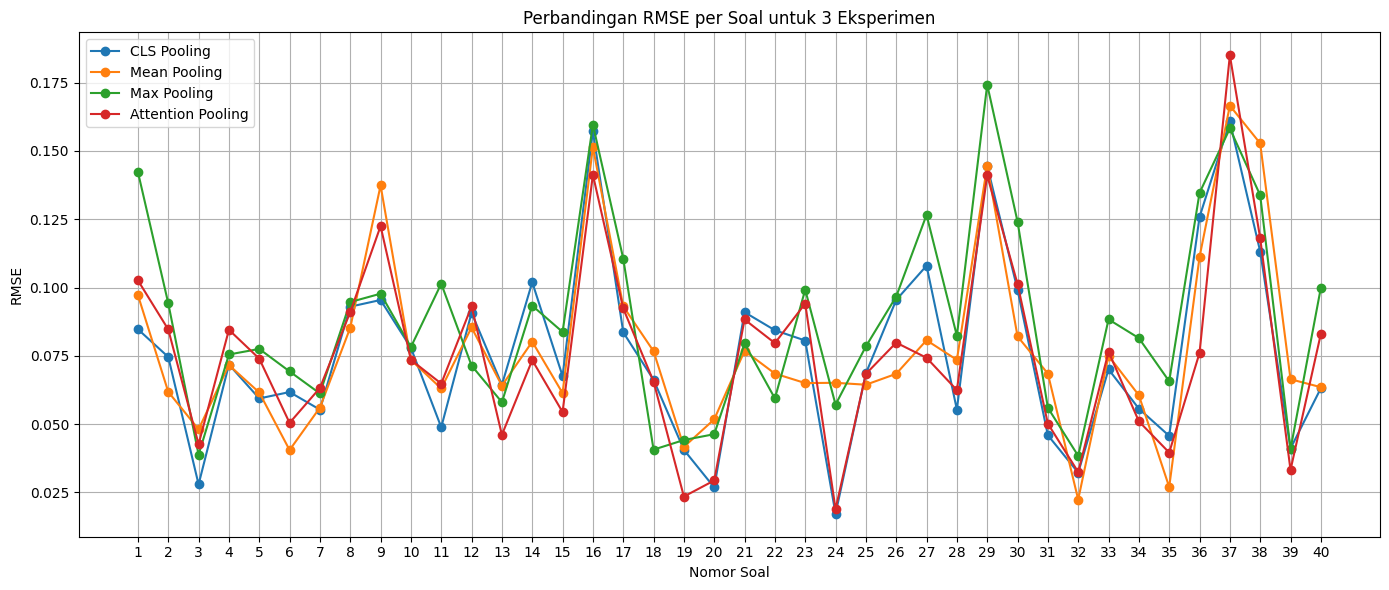

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith("1.csv") and f.startswith("bert")]

color_palette = plt.get_cmap("tab10") 

label_map = {
    "predicted_score_0": "CLS Pooling",
    "predicted_score_1": "Mean Pooling",
    "predicted_score_2": "Max Pooling",
    "predicted_score_8": "Attention Pooling",
}

rmse_per_model = {}
metric_eval_data = {}
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col) 
        print(f"\n>> {label} - {col}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    soal_numbers = extract_soal_number(rmse_series.index)
    
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.title("Perbandingan RMSE per Soal untuk 3 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique())) 
plt.tight_layout()
plt.show()



In [15]:
fixed_threshold = 0.1

model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores
        label = label_map.get(col, col)
        model_data.append((label, true_scores, pred_scores, residuals))

model_data = sorted(model_data, key=lambda x: x[0])

num_models = len(model_data)
outlier_count = {}
for i, (label, true_scores, pred_scores, residuals) in enumerate(model_data):
    outlier_fixed2 = np.abs(residuals) > 0.2
    outlier_fixed = np.abs(residuals) > fixed_threshold

    num_outliers_fixed2 = np.sum(outlier_fixed2)
    num_outliers_fixed = np.sum(outlier_fixed)

    print(f"{label}:")
    print(f"  Outlier (Fixed ±0.2): {num_outliers_fixed2}")
    print(f"  Outlier (Fixed ±{fixed_threshold}): {num_outliers_fixed}\n")

Attention Pooling:
  Outlier (Fixed ±0.2): 6
  Outlier (Fixed ±0.1): 43

CLS Pooling:
  Outlier (Fixed ±0.2): 7
  Outlier (Fixed ±0.1): 44

Max Pooling:
  Outlier (Fixed ±0.2): 10
  Outlier (Fixed ±0.1): 50

Mean Pooling:
  Outlier (Fixed ±0.2): 5
  Outlier (Fixed ±0.1): 43

